In [1]:
import sklearn.datasets
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torch

import sklearn.model_selection
from rtdl_revisiting_models import MLP, ResNet, FTTransformer
from sklearn.metrics import r2_score, accuracy_score
from imodels import FIGSRegressor, FIGSClassifier
from imodels.importance import RandomForestPlusRegressor

from tabdl import *

import openml
from ucimlrepo import fetch_ucirepo 

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.base import clone
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

import os

from featurizer_utils import binary_map, bit_repr, get_leaf_node_indices

In [13]:
class GMMBinaryMapper:
    def __init__(self, empty_cat=1, seed=0, max_gmm_components=3):
        self.encoders = {}
        self.maps = {}
        self.feature_types = {}
        self.no_interaction = []
        self.sizes = {}
        self.seed = seed
        self.empty_cat = empty_cat
        self.max_gmm_components = max_gmm_components
        
    def _plot_gmm_with_intersections(self, data, feature_name, gmm, intersections):
        x = np.linspace(data.min(), data.max(), 1000)
        pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))

        plt.figure(figsize=(10, 6))
        plt.hist(data, bins=30, density=True, alpha=0.6, color='gray')
        plt.plot(x, pdf, '-k', lw=2)

        # Plot each Gaussian component
        for mean, cov in zip(gmm.means_, gmm.covariances_):
            component_pdf = (1 / np.sqrt(2 * np.pi * cov)) * np.exp(-(x - mean)**2 / (2 * cov))
            plt.plot(x, component_pdf.reshape(-1, ), '--', lw=2)

        # Plot intersection lines
        for intersection in intersections:
            plt.axvline(x=intersection, color='r', linestyle='--')

        plt.title(f'GMM for feature: {feature_name}')
        plt.xlabel(feature_name)
        plt.ylabel('Density')
        plt.show()
    
    def _fit_gmm_and_find_intersections(self, data, feature_name, plot):
        param_grid = {'n_components': np.arange(1, self.max_gmm_components+1)}
        gmm = GaussianMixture()
        grid_search = GridSearchCV(gmm, param_grid, cv=5)
        grid_search.fit(data.reshape(-1, 1))
        optimal_components = grid_search.best_params_['n_components']
        
        gmm = GaussianMixture(n_components=optimal_components)
        gmm.fit(data.reshape(-1, 1))
        
        means = gmm.means_.flatten()
        variances = gmm.covariances_.flatten()
        
        sorted_indices = np.argsort(means)
        sorted_means = means[sorted_indices]
        sorted_variances = variances[sorted_indices]
        
        intersections = []
        
        for i in range(len(sorted_means) - 1):
            mu1, var1 = sorted_means[i], sorted_variances[i]
            mu2, var2 = sorted_means[i + 1], sorted_variances[i + 1]

            term1 = mu1*var2 - mu2*var1
            term2 = np.sqrt(var1*var2) * np.sqrt((mu1 - mu2)**2 + (var2 - var1) * np.log(var2 / var1))
            term3 = var2 - var1
            intersections.append(((term1 + term2) / term3))
            
        if plot:
            self._plot_gmm_with_intersections(data, feature_name, gmm, intersections)
        
        return intersections
    
    def fit(self, X, plot=False):
        for feature_name in X.columns:
            feature = X[feature_name]
            if pd.api.types.is_float_dtype(feature) and len(feature.unique()) > 10:
                unique_vals = feature.unique()
                if len(unique_vals) == 2:
                    self.maps[feature_name] = binary_map(feature)
                    self.feature_types[feature_name] = 'binary'
                else:
                    intersections = self._fit_gmm_and_find_intersections(feature.values, feature_name, plot)
                    # mapping = defaultdict(lambda: 0)
                    # unique_values = sorted(np.unique(intersections))
                    # mapping.update({val: i + self.empty_cat for i, val in enumerate(unique_values)})
                    # self.maps[feature_name] = mapping
                    self.maps[feature_name] = intersections
                    self.feature_types[feature_name] = 'continuous'
            else:
                encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore' if not self.empty_cat else 'infrequent_if_exist')
                encoded_feature = encoder.fit_transform(feature.values.reshape(-1, 1))
                self.encoders[feature_name] = encoder
                self.feature_types[feature_name] = 'categorical'
                
    def transform(self, X):
        transformed_features = []
        
        for feature_name in X.columns:
            feature = X[feature_name]
            if self.feature_types[feature_name] == 'binary':
                binary_map = self.maps[feature_name]
                transformed_feature = feature.map(binary_map).fillna(0)
                transformed_features.append(transformed_feature)
                
            elif self.feature_types[feature_name] == 'categorical':
                encoder = self.encoders[feature_name]
                transformed_feature = encoder.transform(feature.values.reshape(-1, 1))
                transformed_features.append(pd.DataFrame(transformed_feature, columns=encoder.get_feature_names_out([feature_name])))
            
            elif self.feature_types[feature_name] == 'continuous':
                intersections = self.maps[feature_name]
                regions = []
                
                # Create regions based on intersections
                for i in range(len(intersections) + 1):
                    if i == 0:
                        regions.append((feature <= intersections[i]).astype(int))
                        print((feature <= intersections[i]).astype(int), sum((feature <= intersections[i]).astype(int)))
                    elif i == len(intersections):
                        regions.append((feature > intersections[i-1]).astype(int))
                    else:
                        regions.append(((feature > intersections[i-1]) & (feature <= intersections[i])).astype(int))
                
                for j, region in enumerate(regions):
                    transformed_features.append(pd.Series(region, name=f'{feature_name}_region{j+1}'))
        
        return pd.concat(transformed_features, axis=1)

In [14]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# Load the California housing dataset
housing = fetch_california_housing(as_frame=True)

# Create DataFrames for X and y
X = housing.data
y = housing.target

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting splits
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (16512, 8)
X_test shape: (4128, 8)
y_train shape: (16512,)
y_test shape: (4128,)


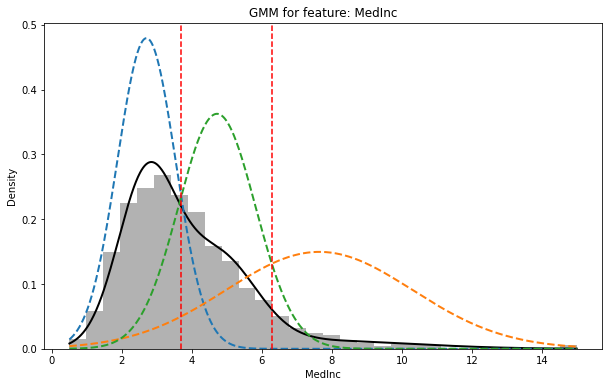

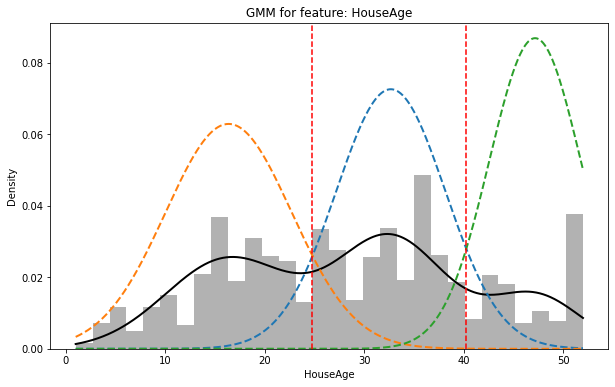

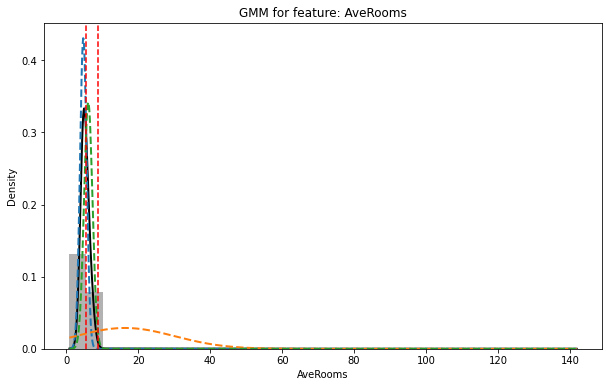

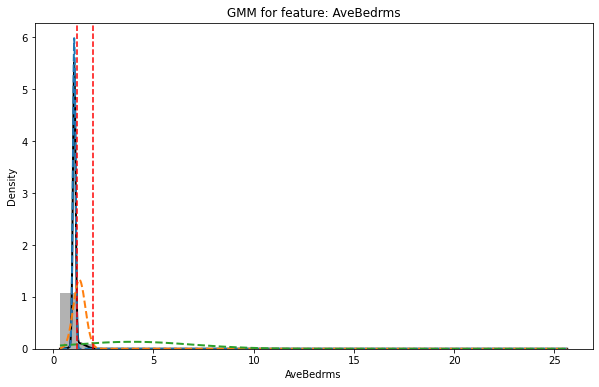

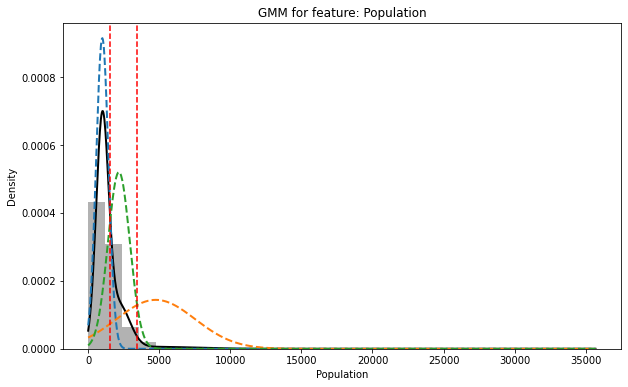

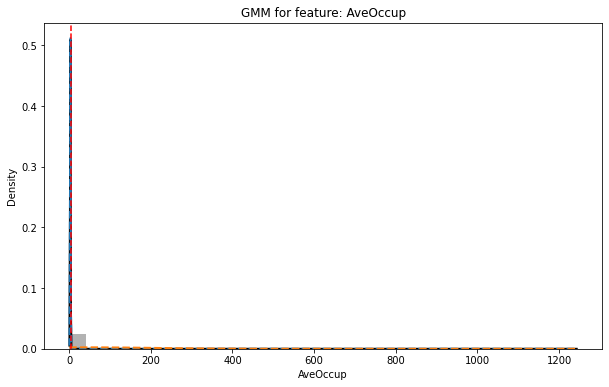

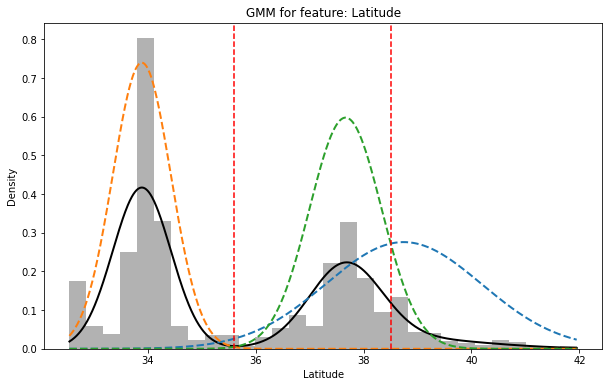

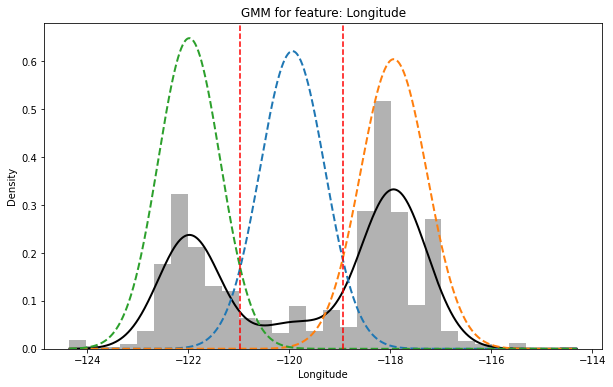

In [15]:
ft = GMMBinaryMapper()
ft.fit(X_train, plot=True)

In [16]:
X_train_new = ft.transform(X_train)

14196    1
8267     0
17445    0
14265    1
2271     1
        ..
11284    0
11964    1
5390     1
860      0
15795    1
Name: MedInc, Length: 16512, dtype: int64 8920
14196    0
8267     0
17445    1
14265    0
2271     0
        ..
11284    0
11964    0
5390     0
860      1
15795    0
Name: HouseAge, Length: 16512, dtype: int64 6466
14196    1
8267     1
17445    0
14265    1
2271     0
        ..
11284    0
11964    0
5390     1
860      0
15795    1
Name: AveRooms, Length: 16512, dtype: int64 9898
14196    1
8267     1
17445    1
14265    1
2271     1
        ..
11284    1
11964    0
5390     1
860      1
15795    1
Name: AveBedrms, Length: 16512, dtype: int64 14693
14196    0
8267     1
17445    1
14265    1
2271     1
        ..
11284    1
11964    0
5390     0
860      0
15795    0
Name: Population, Length: 16512, dtype: int64 11472
14196    1
8267     1
17445    1
14265    1
2271     1
        ..
11284    1
11964    1
5390     1
860      1
15795    1
Name: AveOccup, Length: 16

In [19]:
X_train_new

,MedInc_region1,MedInc_region2,MedInc_region3,HouseAge_region1,HouseAge_region2,HouseAge_region3,AveRooms_region1,AveRooms_region2,AveRooms_region3,AveBedrms_region1,...,Population_region2,Population_region3,AveOccup_region1,AveOccup_region2,Latitude_region1,Latitude_region2,Latitude_region3,Longitude_region1,Longitude_region2,Longitude_region3
14196,1,0,0,0,1,0,1,0,0,1,...,1,0,1,0,1,0,0,0,0,1
8267,0,1,0,0,0,1,1,0,0,1,...,0,0,1,0,1,0,0,0,0,1
17445,0,1,0,1,0,0,0,1,0,1,...,0,0,1,0,1,0,0,0,1,0
14265,1,0,0,0,1,0,1,0,0,1,...,0,0,1,0,1,0,0,0,0,1
2271,1,0,0,0,0,1,0,1,0,1,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0,0,1,0,1,0,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
11964,1,0,0,0,1,0,0,1,0,0,...,1,0,1,0,1,0,0,0,0,1
5390,1,0,0,0,1,0,1,0,0,1,...,1,0,1,0,1,0,0,0,0,1
860,0,1,0,1,0,0,0,1,0,1,...,1,0,1,0,0,1,0,1,0,0


In [8]:
ft.maps

{'MedInc': defaultdict(<function __main__.GMMBinaryMapper.fit.<locals>.<lambda>()>,
             {3.7244455909928647: 1, 6.338276549651098: 2, 0: 0, 1: 0, 2: 0}),
 'HouseAge': defaultdict(<function __main__.GMMBinaryMapper.fit.<locals>.<lambda>()>,
             {24.198620567743806: 1, 39.4687441632157: 2, 0: 0, 1: 0, 2: 0}),
 'AveRooms': defaultdict(<function __main__.GMMBinaryMapper.fit.<locals>.<lambda>()>,
             {5.556646598602255: 1, 8.83247843893032: 2, 0: 0, 1: 0, 2: 0}),
 'AveBedrms': defaultdict(<function __main__.GMMBinaryMapper.fit.<locals>.<lambda>()>,
             {1.1662640559871846: 1, 1.9700342117333065: 2, 0: 0, 1: 0, 2: 0}),
 'Population': defaultdict(<function __main__.GMMBinaryMapper.fit.<locals>.<lambda>()>,
             {1568.4661784876473: 1, 3444.9976416417885: 2, 0: 0, 1: 0, 2: 0}),
 'AveOccup': defaultdict(<function __main__.GMMBinaryMapper.fit.<locals>.<lambda>()>,
             {1243.1393785871821: 1, 0: 0, 1: 0}),
 'Latitude': defaultdict(<function __m